In [ ]:
# Install the necessary dependencies

import os
import sys 
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython imageio scikit-image requests pillow

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Deepdream in TensorFlow
Note: There is no new code in this script. It originates from the TensorFlow tutorial located here. However, this code is modified slightly to run on Python 3. The code is also commented very heavily to explain, line-by-line, what occurs in the deepdream demo.

Here are some potential outputs.

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/CNN/06_deepdream_ex.png
name: Deepdream outputs
:::

## Code

Using TensorFlow for Deep Dream

From: Alexander Mordvintsev
https://www.tensorflow.org/tutorials/generative/deepdream

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

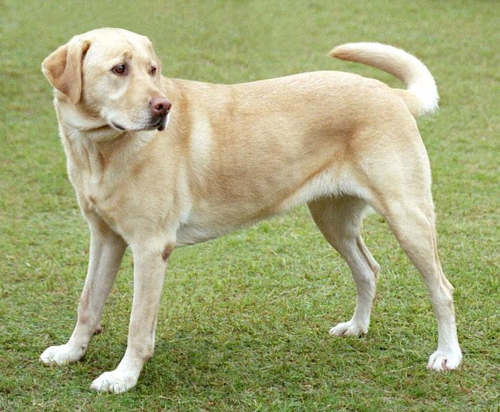

In [4]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [6]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [7]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [8]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [9]:
deepdream = DeepDream(dream_model)

In [10]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

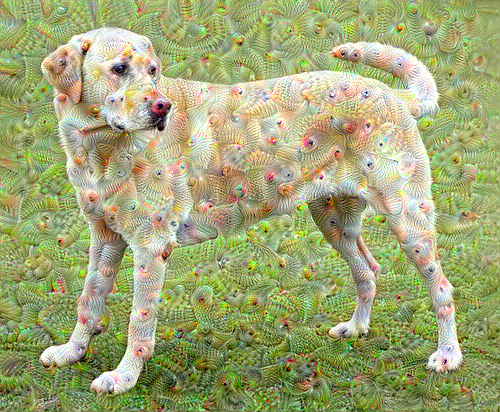

In [11]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

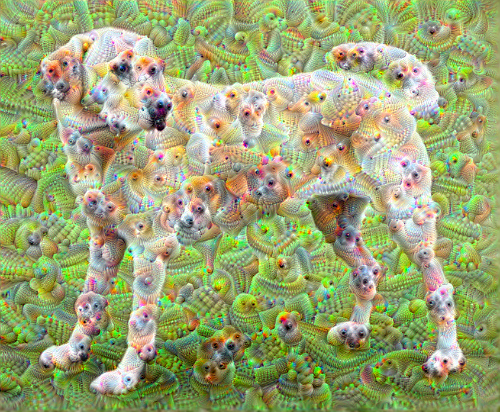

6.457822322845459

In [12]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

## Your turn! 🚀

TBD.

## Acknowledgments

Thanks to [TensorFlow](https://www.tensorflow.org/) for creating the open source project [DeepDream](https://www.tensorflow.org/tutorials/generative/deepdream). It inspires the majority of the content in this chapter.
